Install and import packages needed for the project

!pip install gym_super_mario_bros==7.3.0 nes_py

In [1]:
#Import the game
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [ ]:
#Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True,render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [ ]:
# Create a flag - restart or not
done = True
for step in range(100000):
    if done:
        env.reset()
    state, reward, done, info,_ = env.step(env.action_space.sample())
    env.render()
env.close()

Preprocessing data

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [ ]:
!pip install stable-baselines3[extra]


In [3]:
from gym.wrappers import FrameStack, GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [5]:
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)

In [ ]:
# Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0', apply_api_compatibility=True,render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = GrayScaleObservation(env, keep_dim=True)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [87]:
state = env.reset()

In [85]:
state, reward, done, info = env.step([5])

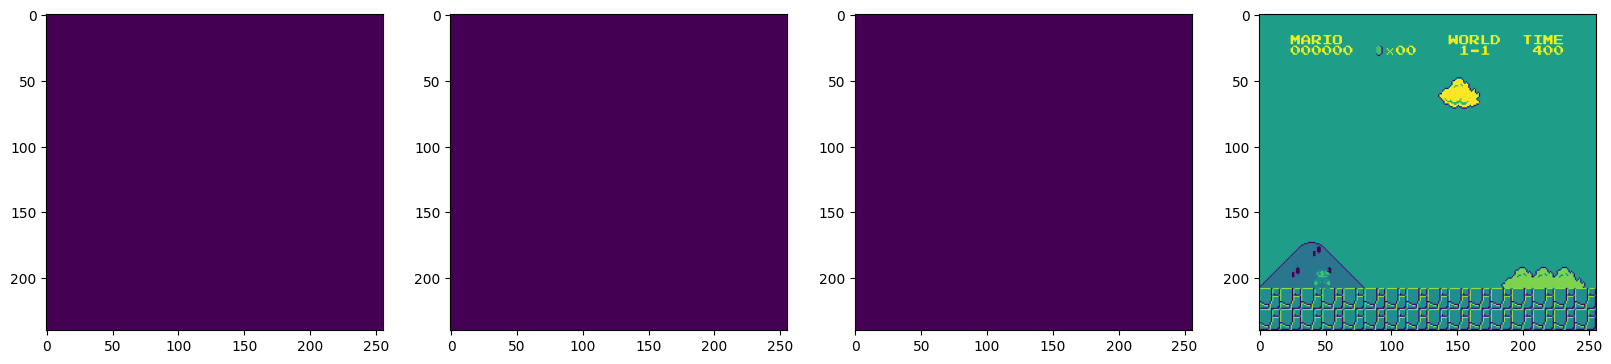

In [88]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

Build deep learning model and save file class

In [7]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [8]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [9]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [10]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [11]:
#AI model create
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001,
            n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


Train the model

In [ ]:
#AI model training
model.learn(total_timesteps=1000000, callback=callback)

Save and test the result

In [12]:
model.save('thisisatestmodel')

In [14]:
#Test model
model = PPO.load('./train/best_model_100000')

In [ ]:
state = env.reset()
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()